# MNIST Image Classification Using LeNet

In this tutorial, we are going to walk through the logic in `lenet_mnist.py` shown below and provide step-by-step instructions.

In [ ]:
!cat lenet_mnist.py

## Step 1: Prepare training and evaluation dataset, create FastEstimator `Pipeline`

`Pipeline` can take both data in memory and data in disk. In this example, we are going to use data in memory by loading data with `tf.keras.datasets.mnist`

In [ ]:
import tensorflow as tf
(x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.mnist.load_data()
print("train image shape is {}".format(x_train.shape))
print("train label shape is {}".format(y_train.shape))
print("eval image shape is {}".format(x_eval.shape))
print("eval label shape is {}".format(y_eval.shape))

The convolution layer requires channel dimension (batch, height, width, channel), therefore, we need to expand the training image and evaluation image by one dimension:

In [ ]:
import numpy as np
x_train = np.expand_dims(x_train, -1)
x_eval = np.expand_dims(x_eval, -1)
print("train image shape is {}".format(x_train.shape))
print("eval image shape is {}".format(x_eval.shape))

For in-memory data in `Pipeline`, the data format should be a nested dictionary like: {"mode1": {"feature1": numpy_array, "feature2": numpy_array, ...}, ...}. Each `mode` can be either `train` or `eval`, in our case, we have both `train` and `eval`.  `feature` is the feature name, in our case, we have `x` and `y`.

In [4]:
data = {"train": {"x": x_train, "y": y_train}, "eval": {"x": x_eval, "y": y_eval}}

Now we are ready to define `Pipeline`, we want to apply a `Minmax` online preprocessing to the image feature `x` for both training and evaluation:

In [5]:
import fastestimator as fe
from fastestimator.pipeline.processing import Minmax
pipeline = fe.Pipeline(batch_size=32, data=data, ops=Minmax(inputs="x", outputs="x"))

## Step 2: Prepare model, create FastEstimator `Network`

First, we have to define the network architecture in `tf.keras.Model` or `tf.keras.Sequential`, for a popular architecture like LeNet, FastEstimator has it implemented already in [fastestimator.architecture.lenet](https://github.com/fastestimator/fastestimator/blob/master/fastestimator/architecture/lenet.py).  After defining the architecture, users are expected to feed the architecture definition and its associated model name, optimizer and loss name (default to be 'loss') to `FEModel`.

In [6]:
from fastestimator.architecture import LeNet
from fastestimator.network.model import FEModel
model = FEModel(model_def=LeNet, model_name="lenet", optimizer="adam", loss_name="loss")

Now we are ready to define the `Network`: given with a batch data with key `x` and `y`, we have to work our way to `loss` with series of operators.  `ModelOp` is an operator that contains a model.

In [7]:
from fastestimator.network.model import ModelOp
from fastestimator.network.loss import SparseCategoricalCrossentropy
network = fe.Network(ops=[ModelOp(inputs="x", model=model, outputs="y_pred"), 
                          SparseCategoricalCrossentropy(y_pred="y_pred", y_true="y", outputs="loss")])

# Step 3: Configure training, create `Estimator`

During the training loop, we want to: 1) measure accuracy for data data 2) save the model with lowest valdiation loss. `Trace` class is used for anything related to training loop, we will need to import the `Accuracy` and `ModelSaver` trace.

In [8]:
import tempfile
from fastestimator.estimator.trace import Accuracy, ModelSaver
save_dir = tempfile.mkdtemp()
traces = [Accuracy(true_key="y", pred_key="y_pred", output_name='acc'),
          ModelSaver(model_name="lenet", save_dir=save_dir, save_best=True)]

Now we can define the `Estimator` and specify the training configuation:

In [9]:
estimator = fe.Estimator(network=network, pipeline=pipeline, epochs=2, traces=traces)

# Start Training
training time takes ~1min on CPU of Mac Book Pro

In [ ]:
estimator.fit()

## Inferencing

After training, the model is saved to a temporary folder. we can load the model from file and do inferencing on a sample image.

In [11]:
import os
model_path = os.path.join(save_dir, 'lenet_best_loss.h5')
trained_model = tf.keras.models.load_model(model_path, compile=False)

Randomly get one image from validation set and compare the ground truth with model prediction:

test image idx 387, ground truth: 2
model predicted class is 2


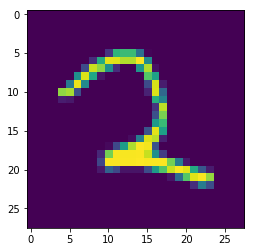

In [12]:
import matplotlib.pyplot as plt

selected_idx = np.random.randint(10000)
print("test image idx {}, ground truth: {}".format(selected_idx, y_eval[selected_idx]))
plt.imshow(x_eval[selected_idx, :, :, 0])

test_image = x_eval[selected_idx]
test_image = np.expand_dims(test_image, 0)
prediction_score = trained_model.predict(test_image)
print("model predicted class is {}".format(np.argmax(prediction_score)))